In [1]:
import os
import json
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import sys
sys.path.insert(0, "..")
from Algorithms.LExaBan.BanzhafCircuit import DNFCircuit as LExaBan
from Algorithms.LExaShap.ShapleyCircuit import DNFCircuit as LExaShap
from Algorithms.Max_LExaBan.ArithmeticCircuit import ArithmeticCircuit


In [2]:
lineages = []
with ZipFile(os.path.join("Example Data", 'Academic.zip'), 'r') as academic_zip:
    for file_name in academic_zip.namelist():
        with academic_zip.open(file_name) as f:
            if file_name.endswith('.json'):
                data = json.load(f)
                results = data.get("results", [])
                for result in results:
                    if len(result.get("dnf", "")) < 10000:
                        lineages.append((file_name[:-5], result.get("tuple_id", ""), result.get("dnf", "")))
print(len(lineages))


7865


In [3]:
def parse_lineage(lineage):
    """
    Parses a lineage string into a better working format.
    """
    numbered_mapping = dict()
    vars = set()
    for clause in lineage:
        vars.update(clause)
    for idx, var in enumerate(vars):
        numbered_mapping[var] = idx
    res = [set([numbered_mapping[fact] for fact in clause]) for clause in lineage]
    return res

In [4]:
runtimes = []
for i, lineage in enumerate(lineages):
    # if i == 2341:
    if i == 2430:
        continue # skipping the lineage that takes very long to compute and only possible on strong hardware computers (see Section 5.3 in the paper)
    start = time.time()
    c = LExaBan(parse_lineage(lineage[2]))
    end = time.time()
    runtimes.append((lineage[0], lineage[1], 'LExaBan', end - start))
    try:
        start = time.time()
        c = LExaShap(parse_lineage(lineage[2]))
        end = time.time()
        runtimes.append((lineage[0], lineage[1], 'LExaShap', end - start))
    except Exception as e:
        runtimes.append((lineage[0], lineage[1], 'LExaShap', -1))
    if i % 1000 == 0:
        print(f"Processed {i} lineages")

df = pd.DataFrame(runtimes, columns=["Query", "Output Tuple", "Algorithm", "Run Time"])
    

Processed 0 lineages
Processed 1000 lineages


c:\Users\omera\OneDrive\Documents\GitHub\LExaBan-LExaShap\Notebooks\..\Algorithms\LExaShap\ShapleyEngine.py:175: RuntimeWarning: overflow encountered in conversion from python long
  self.grad = np.array([0,*[(factorial(i) * factorial(len(self.vars) - i - 1)) for i in range(len(self.vars))]], dtype=np.longdouble)


Processed 2000 lineages
Processed 3000 lineages
Processed 4000 lineages
Processed 5000 lineages
Processed 6000 lineages
Processed 7000 lineages


In [9]:
def summarize_algorithm(df):
    summary = []
    for algo in df['Algorithm'].unique():
        sub = df[df['Algorithm'] == algo]
        valid = sub[sub['Run Time'] != -1]
        total = len(sub)
        success = len(valid)
        success_rate = success / total if total > 0 else np.nan
        runtimes = valid['Run Time'].values
        mean_rt = np.mean(runtimes) if len(runtimes) > 0 else np.nan
        percentiles = np.percentile(runtimes, [50, 90, 95, 99]) if len(runtimes) > 0 else [np.nan]*4
        max_rt = np.max(runtimes) if len(runtimes) > 0 else np.nan
        summary.append({
            "Algorithm": algo,
            "Success Rate": success_rate,
            "Mean Runtime": mean_rt,
            "p50": percentiles[0],
            "p90": percentiles[1],
            "p95": percentiles[2],
            "p99": percentiles[3],
            "Max": max_rt
        })
    return pd.DataFrame(summary).set_index("Algorithm")

algo_summary = summarize_algorithm(df)
algo_summary

,Success Rate,Mean Runtime,p50,p90,p95,p99,Max
Algorithm,,,,,,,
LExaBan,1.000000,0.002443,0.0,0.000587,0.001509,0.049694,3.788608
LExaShap,0.988428,0.010383,0.0,0.006033,0.014727,0.039346,31.530828


C:\Users\omera\AppData\Local\Temp\ipykernel_20904\1365961747.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(x="Variable Bin", y="Run Time", hue="Algorithm", data=merged_df, ax=axes[0], palette=palette, showfliers=False)
C:\Users\omera\AppData\Local\Temp\ipykernel_20904\1365961747.py:33: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(x="Clause Bin", y="Run Time", hue="Algorithm", data=merged_df, ax=axes[1], palette=palette, showfliers=False)


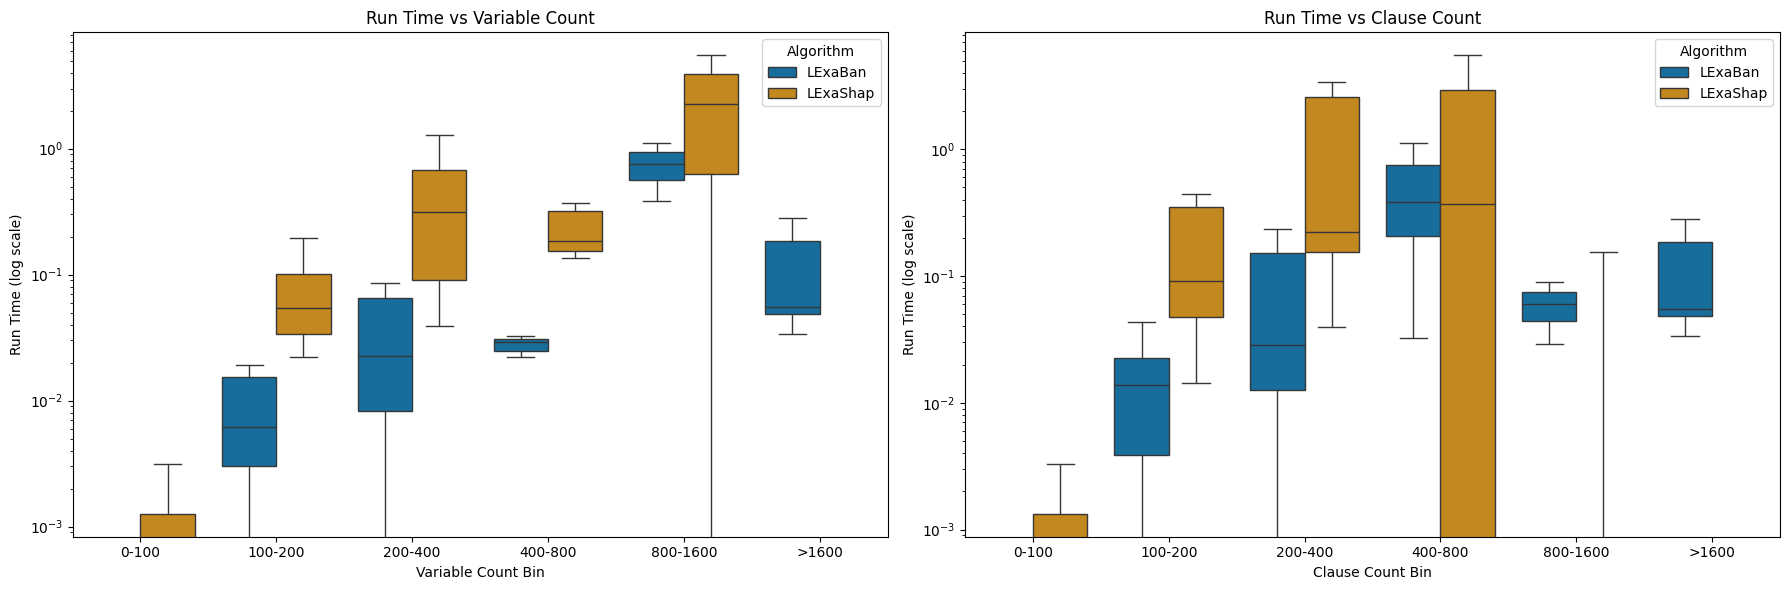

C:\Users\omera\AppData\Local\Temp\ipykernel_20904\1365961747.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_var_bin = success_var_bin.groupby(["Variable Bin", "Algorithm"])["Success"].mean().reset_index()
C:\Users\omera\AppData\Local\Temp\ipykernel_20904\1365961747.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate_clause_bin = success_clause_bin.groupby(["Clause Bin", "Algorithm"])["Success"].mean().reset_index()
C:\Users\omera\AppData\Local\Temp\ipykernel_20904\1365961747.py:53: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
 

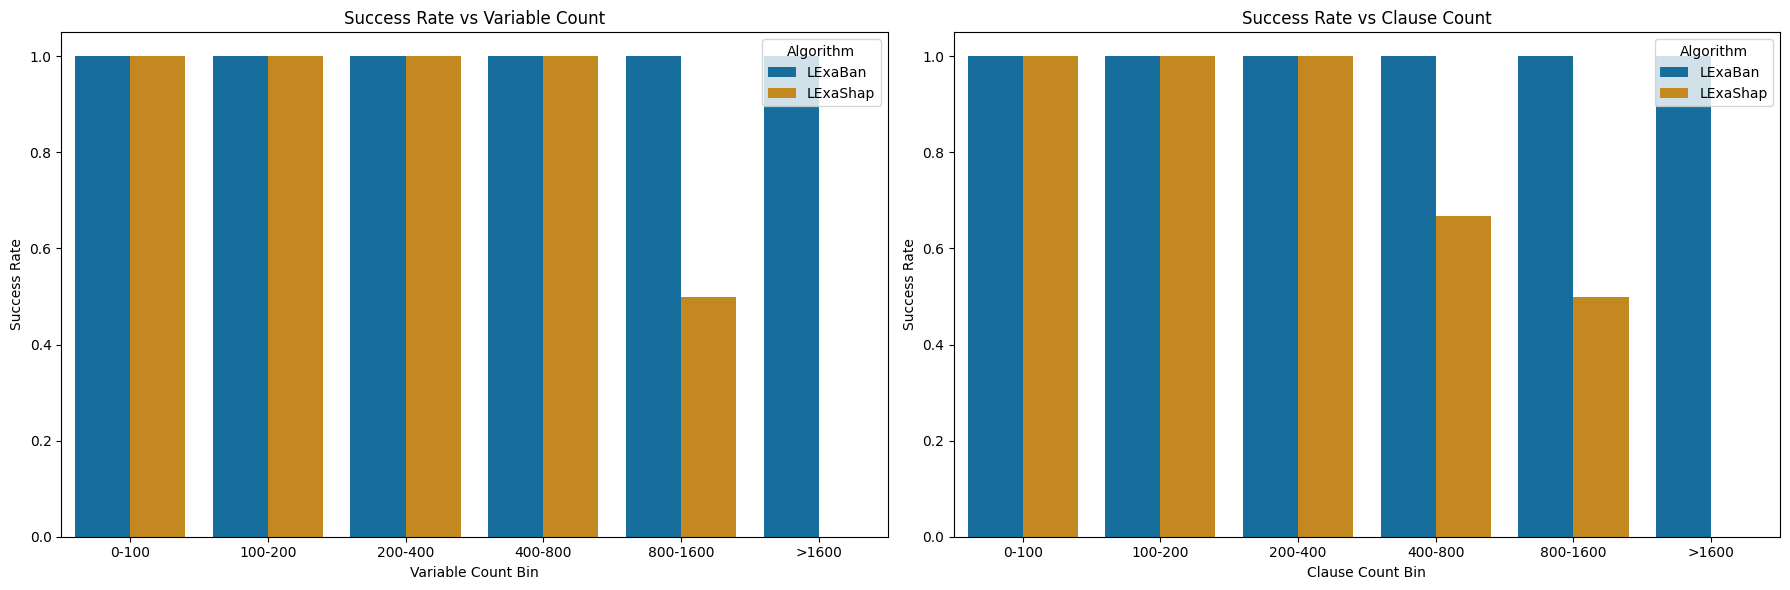

In [6]:
# Collect number of clauses and variables for each DNF
prov_stats = []
for query, tuple_id, dnf in lineages:
    clause_count = len(dnf)
    var_set = set()
    for clause in dnf:
        var_set.update(clause)
    var_count = len(var_set)
    prov_stats.append((query, tuple_id, clause_count, var_count))

prov_df = pd.DataFrame(prov_stats, columns=["Query", "Output Tuple", "Clause Count", "Variable Count"])

# Merge provenance info with runtime info
merged_df = df.merge(prov_df, on=["Query", "Output Tuple"], how="left")

# Define bins and labels
bins = [0, 100, 200, 400, 800, 1600, np.inf]
labels = ["0-100", "100-200", "200-400", "400-800", "800-1600", ">1600"]

palette= sns.color_palette("colorblind")
# Bin Variable Count and Clause Count
merged_df['Variable Bin'] = pd.cut(merged_df['Variable Count'], bins=bins, labels=labels, right=False)
merged_df['Clause Bin'] = pd.cut(merged_df['Clause Count'], bins=bins, labels=labels, right=False)

# Set up side-by-side plots for runtime
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(x="Variable Bin", y="Run Time", hue="Algorithm", data=merged_df, ax=axes[0], palette=palette, showfliers=False)
axes[0].set_yscale('log')
axes[0].set_title("Run Time vs Variable Count")
axes[0].set_xlabel("Variable Count Bin")
axes[0].set_ylabel("Run Time (log scale)")

sns.boxplot(x="Clause Bin", y="Run Time", hue="Algorithm", data=merged_df, ax=axes[1], palette=palette, showfliers=False)
axes[1].set_yscale('log')
axes[1].set_title("Run Time vs Clause Count")
axes[1].set_xlabel("Clause Count Bin")
axes[1].set_ylabel("Run Time (log scale)")

plt.tight_layout()
plt.show()

# Prepare success rate by bins
success_var_bin = merged_df.copy()
success_var_bin["Success"] = success_var_bin["Run Time"] != -1
success_rate_var_bin = success_var_bin.groupby(["Variable Bin", "Algorithm"])["Success"].mean().reset_index()

success_clause_bin = merged_df.copy()
success_clause_bin["Success"] = success_clause_bin["Run Time"] != -1
success_rate_clause_bin = success_clause_bin.groupby(["Clause Bin", "Algorithm"])["Success"].mean().reset_index()

# Set up side-by-side plots for success rate
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(x="Variable Bin", y="Success", hue='Algorithm', data=success_rate_var_bin, ax=axes[0], palette=palette)
axes[0].set_title("Success Rate vs Variable Count")
axes[0].set_ylabel("Success Rate")
axes[0].set_xlabel("Variable Count Bin")

sns.barplot(x="Clause Bin", y="Success", hue='Algorithm', data=success_rate_clause_bin, ax=axes[1], palette=palette)
axes[1].set_title("Success Rate vs Clause Count")
axes[1].set_ylabel("Success Rate")
axes[1].set_xlabel("Clause Count Bin")

plt.tight_layout()
plt.show()

In [16]:
with open(os.path.join('Example Data', 'q5_runs.pkl'), 'rb') as f:
    runs = pickle.load(f)
print(len(runs))
times = []
for r in runs:
    if r[0] > 0:
        semimodule = r[1]
        start = time.time()
        ArithmeticCircuit(semimodule)
        end = time.time()
        # print(r[0], end-start, len(semimodule))
        times.append((r[0], end-start, len(semimodule)))

300


59 59 59


C:\Users\omera\AppData\Local\Temp\ipykernel_20904\535350553.py:27: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.lineplot(


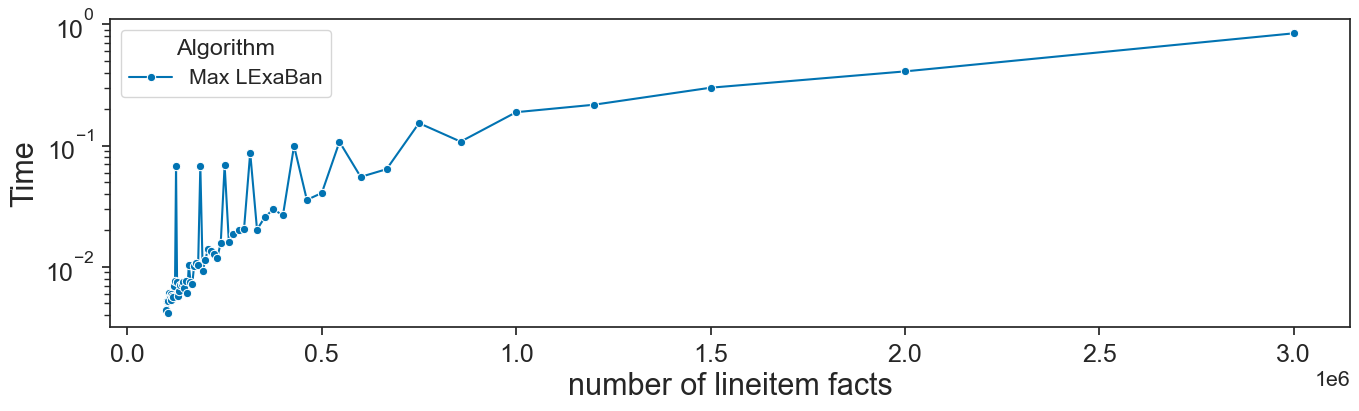

In [17]:
group_size = 5
num_groups = len(times) // group_size

x_axis = [6000000 / (times[group_size * i][0] + 1) for i in range(num_groups)]

avg_lifted = [
    sum(times[group_size * i + j][1] for j in range(group_size)) / group_size
    for i in range(num_groups)
]
print(len(x_axis), len(avg_lifted), num_groups)
df_avg = pd.DataFrame({
    'Lineitem facts count': x_axis,
    'Run time':  avg_lifted,
    'Algorithm':  ['Max LExaBan'] * num_groups
})

plt.figure(figsize=(16, 4))
plt.style.use('seaborn-v0_8-paper')
palette = sns.color_palette("colorblind")
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 36})
plt.axes.labelsize = 36
plt.xticks.labelsize = 36
plt.yticks.labelsize = 36
sns.set(font_scale=1.4, context='notebook', style='ticks')

sns.lineplot(
    data=df_avg,
    x='Lineitem facts count',
    y='Run time',
    hue='Algorithm',
    marker='o',
    palette=palette
)

plt.ylabel("Time", fontsize=22)
plt.yscale('log')
plt.xlabel("number of lineitem facts", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()